In [1]:
import torch
import pandas as pd
import numpy as np
import os
from models import model_init
from data_provider.data_factory import data_provider
import matplotlib.pyplot as plt
from utils.task import ahead_task_parser
from utils.tools import dotdict
import yaml, json

In [3]:
model = 'PatchTST'
data = 'solar'
ahead = 'day'
version = 'latest'
ckpt_base = './checkpoints'

ckpt_id = f'_{model}_{data}_{ahead}_ahead'

if version == 'latest':
    # find all the path that end with the ckpt_id
    ckpt_paths = [os.path.join(ckpt_base, i) for i in os.listdir(ckpt_base) if i.endswith(ckpt_id)]
    # the path is in format of yyyy-mm-dd{ckpt_id}, now find the latest one
    ckpt_paths.sort()
    ckpt_path = ckpt_paths[-1]
else:
    ckpt_path = version + ckpt_id

config = dotdict(json.load(open(os.path.join(ckpt_path, 'args.json'))))
config.model_config = dotdict(config.model_config)
config.data_config = dotdict(config.data_config)

config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config.batch_size = 1

In [4]:
id_data = data_provider(config, 'test', None)

Loading datasets: 100%|██████████| 9/9 [00:04<00:00,  1.83it/s]


In [5]:
id_data = id_data[0]
id_data.keys()

dict_keys(['314106', '319086', '164440', '355827', '331901', '332785', '577650', '551172', '570079'])

In [6]:
model = model_init(config.model, config.model_config, config).to(config.device)
# load the model
model.load_state_dict(torch.load(os.path.join(ckpt_path, 'checkpoint.pth')))

<All keys matched successfully>

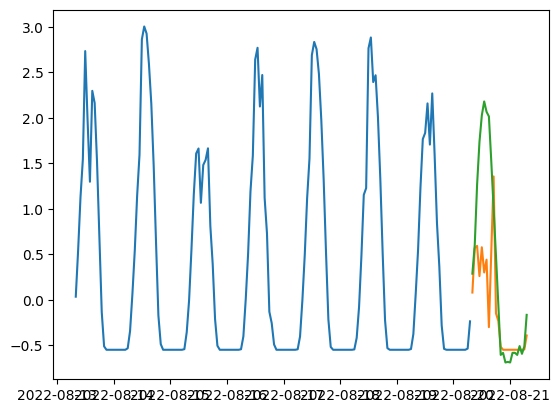

In [7]:
sample_num = 5600 - 24*9
input_data, output_data, indate, outdate = id_data['314106'][sample_num]
input_data = torch.tensor(input_data).to(config.device).float()
output_data = torch.tensor(output_data).to(config.device).float()

output = model(input_data.unsqueeze(0))
output = output[:, -config.output_len:, :]
indate = [str(i) for i in indate]
outdate = [str(i) for i in outdate]
# convert the yyyymmddHHMMSS to datetime
indate = pd.to_datetime(indate, format='%Y%m%d%H%M%S')
outdate = pd.to_datetime(outdate, format='%Y%m%d%H%M%S')
# reformat the indate as datetime
# plot the result
# enable inline plotting
%matplotlib inline
plt.plot(indate, input_data.cpu().detach().numpy().squeeze(), label='input')
plt.plot(outdate, output_data.cpu().detach().numpy().squeeze(), label='target')
plt.plot(outdate, output.cpu().detach().numpy().squeeze(), label='prediction')

In [8]:
indate

array([20220816080000, 20220816090000, 20220816100000, 20220816110000,
       20220816120000, 20220816130000, 20220816140000, 20220816150000,
       20220816160000, 20220816170000, 20220816180000, 20220816190000,
       20220816200000, 20220816210000, 20220816220000, 20220816230000,
       20220817000000, 20220817010000, 20220817020000, 20220817030000,
       20220817040000, 20220817050000, 20220817060000, 20220817070000,
       20220817080000, 20220817090000, 20220817100000, 20220817110000,
       20220817120000, 20220817130000, 20220817140000, 20220817150000,
       20220817160000, 20220817170000, 20220817180000, 20220817190000,
       20220817200000, 20220817210000, 20220817220000, 20220817230000,
       20220818000000, 20220818010000, 20220818020000, 20220818030000,
       20220818040000, 20220818050000, 20220818060000, 20220818070000,
       20220818080000, 20220818090000, 20220818100000, 20220818110000,
       20220818120000, 20220818130000, 20220818140000, 20220818150000,
      